In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
from kan.custom_utils import remove_outliers_iqr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

dir_current = os.getcwd()
dir_parent = os.path.dirname(dir_current)
filepath = os.path.join(dir_parent, "TaeWoong", "25.01.14_CO2RR_GSA.xlsx")

xls = pd.ExcelFile(filepath)
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

This script is running on cpu.
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---



In [2]:
name_X = [
    "Current density (mA/cm2)",
    "Faradaic efficiency (%)",
    "CO coversion",
    "Voltage (V)",
    "Electricity cost ($/kWh)",
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)",
    "Crossover rate"
]
name_y = "Required energy_total (MJ/kgCO)" # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))

X_norm = scaler_X.fit_transform(X)
y_norm = scaler_y.fit_transform(y)


In [12]:
from SALib.analyze.sobol import analyze

nx = X_norm.shape[1]
y_norm_flat = y_norm.flatten()

denominator = nx * 2 + 2
n_analysis = int(len(y_norm_flat) / denominator) * denominator
y_norm_analysis = y_norm_flat[:n_analysis]

problem = {
    'num_vars': nx,
    'names': [f'x{i}' for i in range(nx)],
    'bounds': [[0.1, 0.9]] * nx
}

Si = analyze(problem, y_norm_analysis, print_to_console=True)

          ST   ST_conf
x0  0.043701  0.023818
x1  0.197623  0.129678
x2  0.347195  0.212828
x3  0.292190  0.137013
x4  0.427226  0.235731
x5  0.523461  0.244173
x6  0.703458  0.352004
x7  0.718079  0.383398
          S1   S1_conf
x0  0.032425  0.023853
x1  0.043683  0.053977
x2  0.065600  0.076378
x3  0.120011  0.065969
x4  0.164361  0.069748
x5  0.218706  0.067632
x6  0.268354  0.076182
x7  0.343883  0.082028
                S2   S2_conf
(x0, x1)  0.460544  0.182269
(x0, x2)  0.513567  0.231693
(x0, x3)  0.536461  0.260202
(x0, x4)  0.605372  0.326388
(x0, x5)  0.677407  0.402208
(x0, x6)  0.776558  0.524045
(x0, x7)  0.737411  0.575392
(x1, x2)  0.389998  0.198471
(x1, x3)  0.404114  0.211978
(x1, x4)  0.452432  0.253463
(x1, x5)  0.500724  0.302053
(x1, x6)  0.570779  0.384986
(x1, x7)  0.549824  0.418428
(x2, x3)  0.292077  0.186988
(x2, x4)  0.336906  0.215514
(x2, x5)  0.381822  0.251655
(x2, x6)  0.448445  0.317094
(x2, x7)  0.459672  0.355054
(x3, x4)  0.200875  0.168833
(x3, x

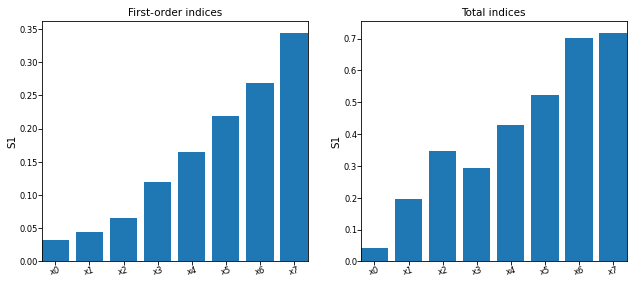

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax1 = axs[0]
ax1.bar(range(1, nx+1), Si['S1'])
ax1.set_xticks(range(1, nx+1))
ax1.set_xticklabels(problem['names'], rotation=15, ha='center')
ax1.set_ylabel('S1')
ax1.set_title('First-order indices')

ax2 = axs[1]
ax2.bar(range(1, nx+1), Si['ST'])
ax2.set_xticks(range(1, nx+1))
ax2.set_xticklabels(problem['names'], rotation=15, ha='center')
ax2.set_ylabel('S1')
ax2.set_title('Total indices')
plt.show()


현존하는 데이터를 가지고 Sobol Analysis를 할 경우에는 직관과 다른 결과를 가져옴. 